# **💎 Language Modeling 💎**



# **1. Import Libs**

Import & Install libraries

In [ ]:
!rm -rf /content/sample_data

In [ ]:
pip install -q torchmetrics

In [ ]:
!pip install -q portalocker>=2.0.0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torchtext
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm

from collections import Counter

In [ ]:
!python --version

Python 3.10.12


In [ ]:
for lib in [np, torch, torchtext, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.23.5
torch --> 2.0.1+cu118
torchtext --> 0.15.2+cpu
tqdm --> 4.66.1


#  **2. Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

Number of trainale parameters

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

#  **3. Dataset**

##  **3-1. Download & Unzip the Dataset**

In [ ]:
train_iter, valid_iter, test_iter = WikiText2('/content/')

In [ ]:
train_iter

ShardingFilterIterDataPipe

In [ ]:
train_iter_ = iter(train_iter)
train_iter_

<generator object ShardingFilterIterDataPipe.__iter__ at 0x7d4aa5ba7990>

In [ ]:
next(train_iter_)

' \n'

## **3-2. Build vocabulary and save it**

🔰 In this section we need to:

*   Define a tokenizer using `basic_english`
*   Tokenize the dataset and collect tokens
*   Build the vocabulary using `build_vocab_from_iterator`
*   Manually insert special tokens and set the default index


In [ ]:
train_iter

ShardingFilterIterDataPipe

In [ ]:
f_train = open('/content/datasets/WikiText2/wikitext-2/wiki_train_tokens.txt')

In [ ]:
f_train2 = f_train.readlines()

In [ ]:
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, f_train2), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [ ]:
len(vocab)

28782

In [ ]:
vocab(['saeideh', 'hi', 'how', 'tehran', 'ali', 'valkyria'])

[0, 9206, 416, 23311, 2284, 3849]

In [ ]:
vocab.get_stoi()

In [ ]:
torch.save(vocab, 'vocab.pt')

In [ ]:
!cp /content/vocab.pt /content/drive/MyDrive/Howsam_Language_Modeling

## **3-3. EDA**

**how many paragraph:**

In [ ]:
len(f_train2)

36718

In [ ]:
f_train2[3]

' Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . \n'

In [ ]:
main_tokens = list(map(tokenizer, f_train2))

In [ ]:
len(main_tokens)

36718

In [ ]:
vocab_dicts = {}
for i in main_tokens:
  for j in i:
    if j not in vocab_dicts.keys():
      vocab_dicts[j] = 1
    else:
      vocab_dicts[j] += 1

In [ ]:
len(vocab_dicts.keys())

28782

**all words in train.txt:**

In [ ]:
count_totall_word = 0
for i in main_tokens:
  for j in i:
    count_totall_word = count_totall_word + len(j)
count_totall_word

8618752

**Most and least common words:**

In [ ]:
# count = 0
count_dict2 = {}
for k, v in vocab_dicts.items():
  # count=count +1
  if v in count_dict2.keys():
    count_dict2[v]+=1
  else:
    count_dict2[v]=1

  # print(f"count {count}: ", k ," ", v)

In [ ]:
count_dict2

{29570: 1,
 54: 63,
 53: 63,
 231: 4,
 5: 2261,
 1702: 1,
 1601: 1,
 54625: 1,
 11992: 1,
 255: 6,
 3: 5130,
 102615: 1,
 29: 154,
 83397: 1,
 57030: 1,
 130768: 1,
 38: 91,
 12004: 1,
 119: 16,
 206: 8,
 39521: 1,
 15058: 1,
 309: 2,
 212: 7,
 11691: 1,
 36523: 1,
 32: 143,
 598: 1,
 16906: 1,
 342: 4,
 725: 2,
 2077: 1,
 429: 3,
 12718: 1,
 9: 991,
 50735: 1,
 262: 4,
 87: 35,
 13794: 1,
 124: 15,
 33: 105,
 979: 2,
 45015: 1,
 693: 2,
 519: 1,
 9273: 1,
 716: 1,
 1498: 1,
 45: 78,
 271: 5,
 2607: 1,
 103: 22,
 3877: 1,
 24: 206,
 545: 1,
 194: 7,
 66: 42,
 4242: 1,
 128: 22,
 12: 646,
 576: 1,
 197: 4,
 104: 22,
 2690: 1,
 1465: 1,
 1370: 1,
 3029: 1,
 113: 17,
 132: 9,
 624: 1,
 325: 2,
 4714: 1,
 1272: 1,
 93: 31,
 8: 1100,
 1102: 1,
 505: 2,
 611: 1,
 65: 52,
 2137: 1,
 856: 1,
 126: 16,
 1083: 2,
 180: 7,
 15140: 1,
 589: 3,
 2127: 1,
 181: 5,
 338: 1,
 3842: 1,
 46: 80,
 1584: 1,
 457: 2,
 2402: 1,
 641: 2,
 55: 61,
 70: 45,
 1448: 1,
 441: 2,
 9229: 1,
 407: 1,
 11: 686,
 957:

In [ ]:
from collections import OrderedDict
dict1 = OrderedDict(sorted(count_dict2.items()))
print(dict1)

OrderedDict([(3, 5130), (4, 3243), (5, 2261), (6, 1740), (7, 1389), (8, 1100), (9, 991), (10, 794), (11, 686), (12, 646), (13, 515), (14, 448), (15, 414), (16, 385), (17, 327), (18, 291), (19, 292), (20, 277), (21, 245), (22, 260), (23, 213), (24, 206), (25, 175), (26, 211), (27, 155), (28, 141), (29, 154), (30, 161), (31, 127), (32, 143), (33, 105), (34, 126), (35, 118), (36, 107), (37, 104), (38, 91), (39, 100), (40, 93), (41, 94), (42, 101), (43, 76), (44, 83), (45, 78), (46, 80), (47, 85), (48, 61), (49, 61), (50, 64), (51, 60), (52, 58), (53, 63), (54, 63), (55, 61), (56, 55), (57, 55), (58, 54), (59, 51), (60, 45), (61, 50), (62, 39), (63, 45), (64, 50), (65, 52), (66, 42), (67, 46), (68, 38), (69, 45), (70, 45), (71, 43), (72, 43), (73, 37), (74, 25), (75, 39), (76, 30), (77, 28), (78, 27), (79, 34), (80, 27), (81, 32), (82, 43), (83, 29), (84, 29), (85, 29), (86, 21), (87, 35), (88, 26), (89, 27), (90, 30), (91, 26), (92, 24), (93, 31), (94, 22), (95, 27), (96, 24), (97, 19), (

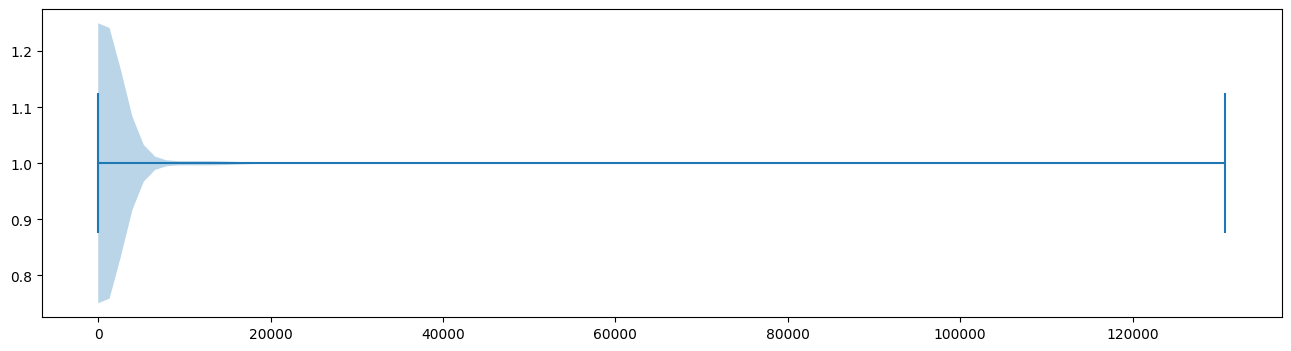

In [ ]:
plt.figure(figsize=(16, 4))
plt.violinplot(dict1, vert=False);

In [ ]:
freqs = Counter()
for tokens in map(tokenizer, f_train2):
  freqs.update(tokens)

In [ ]:
freqs.most_common()[:10]

[('the', 130768),
 (',', 102615),
 ('.', 83397),
 ('of', 57030),
 ('<unk>', 54625),
 ('and', 50735),
 ('in', 45015),
 ('to', 39521),
 ('a', 36523),
 ('=', 29570)]

In [ ]:
freqs.most_common()[-10:]

[('philipp', 3),
 ('prefaced', 3),
 ('kreutzer', 3),
 ('forrester', 3),
 ('zoromski', 3),
 ('roundabouts', 3),
 ('tuscola', 3),
 ('northeasterly', 3),
 ('intergrades', 3),
 ('gallinae', 3)]

## **3-4. Transform the data**

Make sure to perform the transformations on train, validation and test datasets.

🔰 Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

In [ ]:
def data_process(raw_text_iter, seq_len):
  # Create a tensor that is concatenation of all tokens
  data = torch.cat([torch.LongTensor(vocab(tokenizer(line))) for line in raw_text_iter])

  M = len(data) // seq_len

  # We want to reshape our big tensor to M*L. To do this we should be confident that our shape of big tensor is divisible to seq_len
  # If it is not divisible, we add one element at the big tensor.
  r = len(data) % seq_len
  data = torch.cat((data, torch.LongTensor([0]))) if r==0 else data

  # Put aside addition elements
  inputs = data[:M*seq_len]
  inputs = inputs.reshape(-1, seq_len)

  # Target is shifted input
  targets = data[1:M*seq_len+1]
  targets = targets.reshape(-1, seq_len)

  return inputs, targets

In [ ]:
seq_len = 35

X_train, y_train = data_process(f_train2, seq_len)
X_valid, y_valid = data_process(valid_iter, seq_len)
X_test, y_test = data_process(test_iter, seq_len)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

(torch.Size([58571, 35]),
 torch.Size([58571, 35]),
 torch.Size([6126, 35]),
 torch.Size([6126, 35]),
 torch.Size([6910, 35]),
 torch.Size([6910, 35]))

##  **3-5. Custom dataset**

In [ ]:
class LanguageModelDataset(Dataset):

  def __init__(self, inputs, targets):
    self.inputs = inputs
    self.targets = targets

  def __len__(self):
    return self.inputs.shape[0]

  def __getitem__(self, idx):
    input = self.inputs[idx]
    target = self.targets[idx]
    return input, target


In [ ]:
train_set = LanguageModelDataset(X_train, y_train)
valid_set = LanguageModelDataset(X_valid, y_valid)
test_set = LanguageModelDataset(X_test, y_test)

In [ ]:
train_set[0]

(tensor([    9,  3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,
          3869,    21,   780, 28780,     2,  6182,     3,  3849,     4,     1,
          5023,    88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,
           881,   629,   976,     2,    23]),
 tensor([ 3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,  3869,
            21,   780, 28780,     2,  6182,     3,  3849,     4,     1,  5023,
            88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,   881,
           629,   976,     2,    23,     8]))

In [ ]:
train_set[1]

(tensor([    8,  5790,   299,    12,   575,   232,    67,   452,    19, 13722,
             5,   757,     3,  2500,    17,     1,  1767,  5637,     3,   155,
             6,   246,   354,     6,   976,     2,    24,    23,     1,   237,
            67,     6,     1,  3849,    93]),
 tensor([ 5790,   299,    12,   575,   232,    67,   452,    19, 13722,     5,
           757,     3,  2500,    17,     1,  1767,  5637,     3,   155,     6,
           246,   354,     6,   976,     2,    24,    23,     1,   237,    67,
             6,     1,  3849,    93,     3]))

## **3-6. Define dataloader**

In [ ]:
batch_size = 20

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([20, 35]), torch.Size([20, 35]))

#  **4. Model**

🔰 Use the following template to create a custom model.

Your model should consist of three parts:

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

In [ ]:
class LanguageModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_embd=0.5, dropout_rnn=0.5):
    super(LanguageModel, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.embedding.weight.data.uniform_(-0.1, 0.1)
    self.dropout = nn.Dropout(p=dropout_embd)

    # batch_first=True : batch would be first dimension
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout_rnn, batch_first=True)
    self.fc = nn.Linear(hidden_dim, vocab_size)


  def forward(self, src):
    #src = torch.Size([20, 35])
    embed = self.dropout(self.embedding(src)) # torch.Size([20, 35, 300])
    output, hidden = self.lstm(embed) # torch.Size([20, 35, 512])
    out = self.fc(output) # torch.Size([20, 35, 28782])

    return out

In [ ]:
model = LanguageModel(vocab_size=len(vocab),
                      embedding_dim=300,
                      hidden_dim=512,
                      num_layers=2,
                      dropout_embd=0.65,
                      dropout_rnn=0.2)
model

LanguageModel(
  (embedding): Embedding(28782, 300)
  (dropout): Dropout(p=0.65, inplace=False)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=512, out_features=28782, bias=True)
)

In [ ]:
# Number of parameters:
print('params of model : ', num_trainable_params(model))
print('params of embedding : ', num_trainable_params(model.embedding))
print('params of lstm : ', num_trainable_params(model.lstm))
print('params of fc :', num_trainable_params(model.fc))

params of model :  27.168086
params of embedding :  8.6346
params of lstm :  3.76832
params of fc : 14.765166


In [ ]:
model(x_batch)

tensor([[[ 4.8441e-02,  4.9200e-03, -3.1230e-02,  ...,  2.9948e-02,
          -2.1422e-02,  3.6249e-02],
         [ 5.1943e-02,  4.1961e-03, -2.9331e-02,  ...,  2.7712e-02,
          -1.6182e-02,  4.3031e-02],
         [ 5.1409e-02,  4.4374e-03, -2.9819e-02,  ...,  2.6718e-02,
          -1.1984e-02,  4.3330e-02],
         ...,
         [ 5.2457e-02, -1.6718e-03, -2.5586e-02,  ...,  2.5685e-02,
          -9.5652e-03,  4.6753e-02],
         [ 5.1084e-02, -4.3657e-04, -2.5485e-02,  ...,  2.6290e-02,
          -1.0255e-02,  4.7793e-02],
         [ 5.0581e-02, -7.1529e-04, -2.6521e-02,  ...,  2.5671e-02,
          -1.0482e-02,  4.8204e-02]],

        [[ 4.5613e-02,  2.6008e-03, -3.1292e-02,  ...,  2.8676e-02,
          -2.1249e-02,  3.6860e-02],
         [ 4.8185e-02,  6.2106e-04, -3.0777e-02,  ...,  2.4548e-02,
          -1.6352e-02,  4.1242e-02],
         [ 5.0391e-02, -2.3373e-03, -2.9419e-02,  ...,  2.1749e-02,
          -1.2736e-02,  4.3037e-02],
         ...,
         [ 5.2242e-02, -5

# **5. Config**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model = model.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.5, momentum=0.9, weight_decay=0, nesterov=True)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.5
    maximize: False
    momentum: 0.9
    nesterov: True
    weight_decay: 0
)

In [ ]:
metric = tm.text.Perplexity().to(device)
metric

Perplexity()

In [ ]:
clip = 0.25

#  **6. Train**

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      # loss = loss_fn(outputs, targets)
      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
      loss.backward()
      nn.utils.clip_grad.clip_grad_norm_(model.parameters(), max_norm=clip)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

#  **7. Evaluation**

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
      loss_eval.update(loss.item(), n=len(targets))

      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

#  **8. Training Process**

## **8-1. Finding Hyper-parameters**

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [ ]:
model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)

inputs, targets = next(iter(train_loader))

inputs = inputs.to(device) #torch.Size([20, 35])
targets = targets.to(device) #torch.Size([20, 35])

with torch.no_grad():
  outputs = model(inputs) #torch.Size([20, 35, 28782])

  # loss = loss_fn(outputs, targets)
  loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten()) # (torch.Size([700, 28782]) , torch.Size([700]))

print(loss)

tensor(10.2699)


In [ ]:
torch.cuda.empty_cache()

### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [ ]:
model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.9, momentum=0.9)

In [ ]:
mini_train_size = 1000
_, mini_train_dataset = random_split(train_set, (len(train_set)-mini_train_size, mini_train_size))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
num_epochs = 40
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, metric, epoch)

Epoch 19: 100%|██████████| 50/50 [01:40<00:00,  2.02s/batch, loss=1.69, metric=5.41]


### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.
The one with largest decrease is the best

In [ ]:
num_epochs = 3

for lr in [6, 2, 0.9, 0.3, 0.09]:
  print(f'LR={lr}')

  model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)
  # model = torch.load('/content/model-ppl_147.pt')

  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-6, momentum=0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

  print()

LR=6


Epoch 2: 100%|██████████| 2929/2929 [01:54<00:00, 25.62batch/s, loss=5.16, metric=174]



LR=2


Epoch 2: 100%|██████████| 2929/2929 [01:53<00:00, 25.71batch/s, loss=4.99, metric=146]



LR=0.9


Epoch 2: 100%|██████████| 2929/2929 [01:53<00:00, 25.77batch/s, loss=5.21, metric=183]



LR=0.3


Epoch 2: 100%|██████████| 2929/2929 [01:53<00:00, 25.79batch/s, loss=5.76, metric=316]



LR=0.09


Epoch 2: 100%|██████████| 2929/2929 [01:53<00:00, 25.82batch/s, loss=6.44, metric=623]

### 🟡 **Step 4**: Create a small grid using the weight decay and the best learning rate.





In [ ]:
num_epochs = 3

for lr in [1., 2., 3. , 4.]:
  for wd in [1e-6, 1e-4, 1e-5]:
    print(f'LR={lr}, WD={wd}')

    model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

    for epoch in range(num_epochs):
      model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

    print()

LR=1.0, WD=1e-06


Epoch 2: 100%|██████████| 2929/2929 [01:53<00:00, 25.73batch/s, loss=5.17, metric=177]



LR=1.0, WD=0.0001


Epoch 2: 100%|██████████| 2929/2929 [01:53<00:00, 25.86batch/s, loss=5.92, metric=372]



LR=1.0, WD=1e-05


Epoch 2: 100%|██████████| 2929/2929 [01:53<00:00, 25.74batch/s, loss=5.26, metric=192]



LR=2.0, WD=1e-06


Epoch 2: 100%|██████████| 2929/2929 [01:53<00:00, 25.77batch/s, loss=4.99, metric=148]



LR=2.0, WD=0.0001


Epoch 2: 100%|██████████| 2929/2929 [01:53<00:00, 25.91batch/s, loss=5.99, metric=398]



LR=2.0, WD=1e-05


Epoch 2: 100%|██████████| 2929/2929 [01:53<00:00, 25.80batch/s, loss=5.15, metric=172]



LR=3.0, WD=1e-06


Epoch 2: 100%|██████████| 2929/2929 [01:54<00:00, 25.56batch/s, loss=4.97, metric=144]



LR=3.0, WD=0.0001


Epoch 2: 100%|██████████| 2929/2929 [01:53<00:00, 25.84batch/s, loss=6.06, metric=428]



LR=3.0, WD=1e-05


Epoch 2: 100%|██████████| 2929/2929 [01:53<00:00, 25.83batch/s, loss=5.18, metric=177]



LR=4.0, WD=1e-06


Epoch 2: 100%|██████████| 2929/2929 [01:54<00:00, 25.68batch/s, loss=5.03, metric=153]



LR=4.0, WD=0.0001


Epoch 2: 100%|██████████| 2929/2929 [01:54<00:00, 25.62batch/s, loss=6.13, metric=459]



LR=4.0, WD=1e-05


Epoch 2: 100%|██████████| 2929/2929 [01:59<00:00, 24.53batch/s, loss=5.26, metric=192]

### 🟡 **Step 5**: **Train ALL** Train model for longer epochs using the best model from step 4.





We write model and optimizer in different cells. So after 10 epoch if we want to change the learning rate and continue runnig the code, we could just change the optimizer and run that cell again not model cell. Because if we run the model cell too, the model would reset.

#### **First_Try**

In [ ]:
model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)

In [ ]:
# model = torch.load('/content/model-ppl_133.pt')

In [ ]:
lr = 3.0
wd = 1e-06
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 30

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                      valid_loader,
                                      loss_fn,
                                      metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model_{epoch}.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 2929/2929 [01:54<00:00, 25.58batch/s, loss=5.88, metric=359]


Model Saved!
Valid: Loss = 5.323, Metric = 205.1



Epoch 1: 100%|██████████| 2929/2929 [01:54<00:00, 25.65batch/s, loss=5.24, metric=188]


Model Saved!
Valid: Loss = 5.103, Metric = 164.4



Epoch 2: 100%|██████████| 2929/2929 [01:54<00:00, 25.69batch/s, loss=4.97, metric=143]


Model Saved!
Valid: Loss = 5.015, Metric = 150.7



Epoch 3: 100%|██████████| 2929/2929 [01:54<00:00, 25.62batch/s, loss=4.79, metric=120]


Model Saved!
Valid: Loss = 4.977, Metric = 145.1



Epoch 4: 100%|██████████| 2929/2929 [01:54<00:00, 25.61batch/s, loss=4.66, metric=106]


Model Saved!
Valid: Loss = 4.969, Metric = 143.9



Epoch 5: 100%|██████████| 2929/2929 [01:54<00:00, 25.59batch/s, loss=4.56, metric=95.7]


Model Saved!
Valid: Loss = 4.967, Metric = 143.6



Epoch 6: 100%|██████████| 2929/2929 [01:54<00:00, 25.68batch/s, loss=4.48, metric=88.5]


Valid: Loss = 4.967, Metric = 143.6



Epoch 7: 100%|██████████| 2929/2929 [01:54<00:00, 25.63batch/s, loss=4.42, metric=83.2]


Valid: Loss = 4.968, Metric = 143.7



Epoch 8: 100%|██████████| 2929/2929 [01:53<00:00, 25.75batch/s, loss=4.37, metric=78.9]


Valid: Loss = 4.983, Metric = 146.0



Epoch 9: 100%|██████████| 2929/2929 [01:54<00:00, 25.68batch/s, loss=4.32, metric=75.3]


Valid: Loss = 4.984, Metric = 146.0



Epoch 10: 100%|██████████| 2929/2929 [01:53<00:00, 25.73batch/s, loss=4.28, metric=72.4]


Valid: Loss = 5.003, Metric = 148.8



Epoch 11: 100%|██████████| 2929/2929 [01:53<00:00, 25.74batch/s, loss=4.25, metric=70]


Valid: Loss = 5.0, Metric = 148.4



Epoch 12: 100%|██████████| 2929/2929 [01:53<00:00, 25.77batch/s, loss=4.22, metric=67.8]


Valid: Loss = 5.0, Metric = 148.4



Epoch 13: 100%|██████████| 2929/2929 [01:54<00:00, 25.63batch/s, loss=4.19, metric=66]


Valid: Loss = 5.016, Metric = 150.8



Epoch 14: 100%|██████████| 2929/2929 [01:58<00:00, 24.71batch/s, loss=4.17, metric=64.5]


Valid: Loss = 5.025, Metric = 152.2



Epoch 15:   4%|▍         | 121/2929 [00:04<01:54, 24.55batch/s, loss=4.01, metric=55.1]


KeyboardInterrupt: ignored

In [ ]:
!cp /content/model_5.pt /content/drive/MyDrive/howsam_backup

#### **Second_Try**

Check other learning rate for continue..

In [ ]:
num_epochs = 3
for lr in [1., 0.5, 0.05, 0.01]:
  for wd in [1e-6, 1e-4, 1e-5]:
    print(f'LR={lr}, WD={wd}')

    model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)
    model = torch.load('/content/model_5.pt')
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

    for epoch in range(num_epochs):
      model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

    print()

LR=1.0, WD=1e-06


Epoch 2: 100%|██████████| 2929/2929 [01:54<00:00, 25.51batch/s, loss=4.07, metric=58.6]



LR=1.0, WD=0.0001


Epoch 2: 100%|██████████| 2929/2929 [01:54<00:00, 25.65batch/s, loss=5.82, metric=336]



LR=1.0, WD=1e-05


Epoch 2: 100%|██████████| 2929/2929 [01:53<00:00, 25.72batch/s, loss=4.36, metric=78.2]



LR=0.5, WD=1e-06


Epoch 2: 100%|██████████| 2929/2929 [01:54<00:00, 25.66batch/s, loss=4.05, metric=57.6]



LR=0.5, WD=0.0001


Epoch 2: 100%|██████████| 2929/2929 [01:53<00:00, 25.70batch/s, loss=5.7, metric=300]



LR=0.5, WD=1e-05


Epoch 2: 100%|██████████| 2929/2929 [01:54<00:00, 25.63batch/s, loss=4.18, metric=65.1]



LR=0.05, WD=1e-06


Epoch 2: 100%|██████████| 2929/2929 [01:54<00:00, 25.52batch/s, loss=4.17, metric=65]



LR=0.05, WD=0.0001


Epoch 2: 100%|██████████| 2929/2929 [01:54<00:00, 25.58batch/s, loss=4.33, metric=75.6]



LR=0.05, WD=1e-05


Epoch 2: 100%|██████████| 2929/2929 [01:54<00:00, 25.64batch/s, loss=4.18, metric=65.2]



LR=0.01, WD=1e-06


Epoch 2: 100%|██████████| 2929/2929 [01:54<00:00, 25.63batch/s, loss=4.26, metric=70.7]



LR=0.01, WD=0.0001


Epoch 2: 100%|██████████| 2929/2929 [01:54<00:00, 25.62batch/s, loss=4.27, metric=71.7]



LR=0.01, WD=1e-05


Epoch 2: 100%|██████████| 2929/2929 [01:53<00:00, 25.71batch/s, loss=4.26, metric=70.7]

In [ ]:
model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)

In [ ]:
model = torch.load('/content/model_5.pt')

In [ ]:
lr = 0.5
wd = 1e-06
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                      valid_loader,
                                      loss_fn,
                                      metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model_{epoch}.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 2929/2929 [01:54<00:00, 25.53batch/s, loss=4.22, metric=67.7]


Model Saved!
Valid: Loss = 4.877, Metric = 131.2



Epoch 1: 100%|██████████| 2929/2929 [01:54<00:00, 25.55batch/s, loss=4.11, metric=61.1]


Model Saved!
Valid: Loss = 4.876, Metric = 131.1



Epoch 2: 100%|██████████| 2929/2929 [01:54<00:00, 25.60batch/s, loss=4.05, metric=57.6]


Model Saved!
Valid: Loss = 4.873, Metric = 130.7



Epoch 3: 100%|██████████| 2929/2929 [01:58<00:00, 24.74batch/s, loss=4.01, metric=54.9]


Valid: Loss = 4.878, Metric = 131.3



Epoch 4: 100%|██████████| 2929/2929 [02:00<00:00, 24.36batch/s, loss=3.96, metric=52.6]


Valid: Loss = 4.877, Metric = 131.2



Epoch 5: 100%|██████████| 2929/2929 [01:55<00:00, 25.41batch/s, loss=3.93, metric=50.7]


Valid: Loss = 4.878, Metric = 131.3



Epoch 6:   6%|▌         | 165/2929 [00:06<01:47, 25.63batch/s, loss=3.84, metric=46.4]


KeyboardInterrupt: ignored

#### **Third_Try**

In [ ]:
model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)

In [ ]:
model = torch.load('/content/model_1.pt')

In [ ]:
lr = 0.05
wd = 1e-6
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                      valid_loader,
                                      loss_fn,
                                      metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model_{epoch}.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 2929/2929 [01:55<00:00, 25.28batch/s, loss=4.01, metric=54.9]


Model Saved!
Valid: Loss = 4.867, Metric = 129.9



Epoch 1: 100%|██████████| 2929/2929 [01:54<00:00, 25.65batch/s, loss=3.99, metric=54.2]


Model Saved!
Valid: Loss = 4.867, Metric = 129.9



Epoch 2: 100%|██████████| 2929/2929 [01:55<00:00, 25.29batch/s, loss=3.98, metric=53.7]


Valid: Loss = 4.868, Metric = 130.1



Epoch 3: 100%|██████████| 2929/2929 [01:54<00:00, 25.67batch/s, loss=3.97, metric=53.2]


Valid: Loss = 4.868, Metric = 130.1



Epoch 4: 100%|██████████| 2929/2929 [01:55<00:00, 25.28batch/s, loss=3.97, metric=52.8]


Valid: Loss = 4.868, Metric = 130.1



Epoch 5: 100%|██████████| 2929/2929 [01:54<00:00, 25.60batch/s, loss=3.96, metric=52.5]


Valid: Loss = 4.869, Metric = 130.1



Epoch 6:  18%|█▊        | 532/2929 [00:20<01:33, 25.65batch/s, loss=3.95, metric=51.8]


KeyboardInterrupt: ignored

In [ ]:
!cp /content/model_0_ThirdTry.pt /content/drive/MyDrive/howsam_backup
!cp /content/model_1_SecondTry.pt /content/drive/MyDrive/howsam_backup
!cp /content/model_5_FirstTry.pt /content/drive/MyDrive/howsam_backup

##  **8-2. Plot**

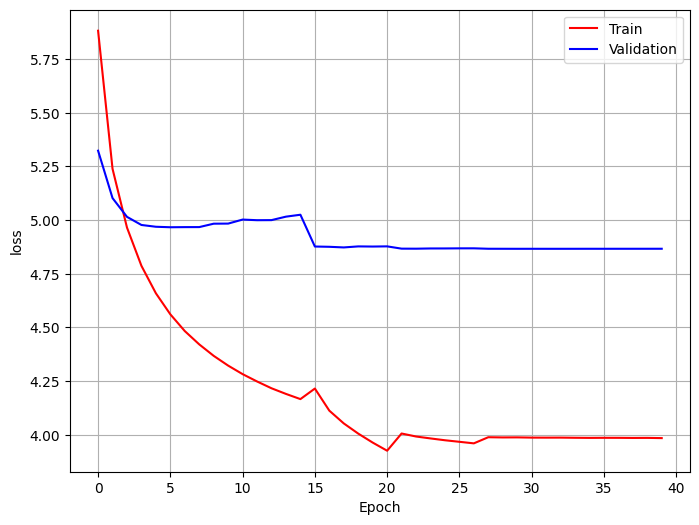

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

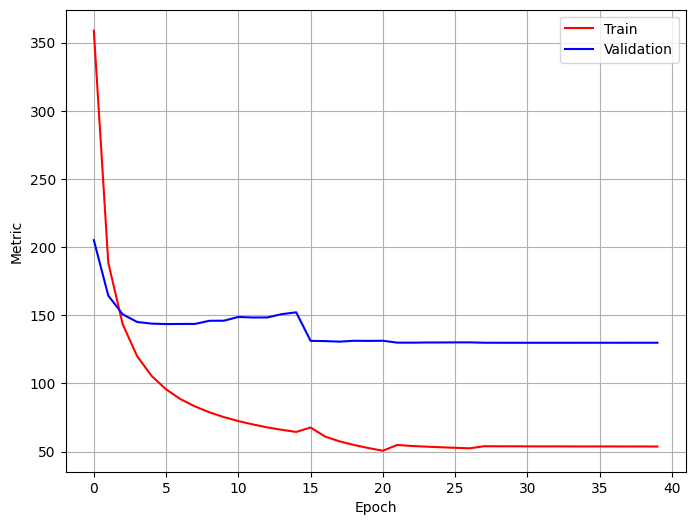

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), metric_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), metric_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.grid(True)
plt.legend()

# **9. Test**

In [ ]:
model_path = '/content/model_0_ThirdTry.pt'
model = torch.load(model_path)
model.eval()

LanguageModel(
  (embedding): Embedding(28782, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=512, out_features=28782, bias=True)
)

In [ ]:
loss_test, metric_test = evaluate(model, test_loader, loss_fn, metric)

In [ ]:
loss_test, metric_test

(4.813559766788731, 123.16915130615234)

# **10. Generate**

🔰 Your mission is to write a `generate` function and use a desired sentence to evaluate the model

In [ ]:
model_path = '/content/model_0_ThirdTry.pt'
model = torch.load(model_path)
model.eval()

LanguageModel(
  (embedding): Embedding(28782, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=512, out_features=28782, bias=True)
)

In [ ]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):
  if seed is not None:
    torch.manual_seed(seed)

  indices = vocab(tokenizer(prompt))
  itos = vocab.get_itos()

  for i in range(max_seq_len):
    src = torch.LongTensor(indices).to(device)

    with torch.no_grad():
      prediction = model(src)

    # Method 1
    # idx = torch.argmax(prediction[-1])
    # itos = vocab.get_itos()
    # itos[idx]

    # Method 2
    probs = torch.softmax(prediction[-1]/temperature, dim=0)

    idx = vocab['<ukn>']
    while idx == vocab['<ukn>']:
      idx = torch.multinomial(probs, num_samples=1).item()

    token = itos[idx]
    prompt += ' ' + token

    if idx == vocab['.']:
      return prompt

    indices.append(idx)

  return prompt

In [ ]:
examples = ['In a galaxy far, far away, there',
            'The sun was setting in the',
            'Once upon a time, there lived a young princess named',
            'What is the meaning ',
            'in the remaining days of this year i',
            'what should i']
seed = 45
for i, example in enumerate(examples):
  print(f"example {i}:")
  print(generate(example, 35, 0.5, model, tokenizer, vocab, seed))
  print()

example 0:
In a galaxy far, far away, there is a mixture of more than one of the most important examples of the universe .

example 1:
The sun was setting in the earth , and the concrete was discovered .

example 2:
Once upon a time, there lived a young princess named the house and the king .

example 3:
What is the meaning  of the poem in which the poem is the only aspect of the poem .

example 4:
in the remaining days of this year i had to be the first and most successful and most successful of the album , and it ' s one of the best @-@ selling albums of all time .

example 5:
what should i want to do .

